In [111]:
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

# Data retrieval and cleaning

In [112]:
df = pd.read_excel('退職予測データ.xlsx','学習データ')

In [113]:
df.head()

,社員ID,退職FLG,部署,役職ランクCD,性別,結婚歴,年齢,雇用形態,勤続年数,勤務先,手当有無,所属子会社名,報酬制度,勤務タイプ,直近1年の残業時間,現ポジションの経過年数
0,1,No,開発,1,男性,結婚,32,3年ごと更新,4.083333,29,あり,ホールディングス,年俸制,客先常駐,82.850,4.083333
1,2,No,開発,1,男性,結婚,41,正社員,2.166667,30,あり,子会社①,年俸制,本社勤務,223.929,0.666667
2,3,No,開発,1,女性,結婚,34,5年ごと更新,4.916667,23,無し,子会社②,年俸制,客先常駐,3.000,4.916667
3,4,No,開発,1,男性,独身,32,3年ごと更新,3.083333,30,無し,子会社①,年俸制,本社勤務,3.250,0.250000
4,5,No,開発,1,男性,結婚,29,1年ごと更新,0.500000,2,あり,子会社①,年俸制,本社勤務,0.000,0.500000


In [114]:
cols_eng = 'employee ID,Retirement FLG,Department,Job rank CD,sex,marital status,age,Employment status,Length of service,workplace,allowance,Affiliated subsidiary name,Compensation system,work type,Overtime hours in the last year,Number of years in current position'.split(',')
cols_eng = [col.replace(" ","_").lower() for col in cols_eng]
cols_jp = [col for col in df.columns]
cols_dict = {}
for idx, col in enumerate(cols_eng):
    cols_dict[col] = cols_jp[idx]
cols_dict
df.columns = cols_eng
df.head()


,employee_id,retirement_flg,department,job_rank_cd,sex,marital_status,age,employment_status,length_of_service,workplace,allowance,affiliated_subsidiary_name,compensation_system,work_type,overtime_hours_in_the_last_year,number_of_years_in_current_position
0,1,No,開発,1,男性,結婚,32,3年ごと更新,4.083333,29,あり,ホールディングス,年俸制,客先常駐,82.850,4.083333
1,2,No,開発,1,男性,結婚,41,正社員,2.166667,30,あり,子会社①,年俸制,本社勤務,223.929,0.666667
2,3,No,開発,1,女性,結婚,34,5年ごと更新,4.916667,23,無し,子会社②,年俸制,客先常駐,3.000,4.916667
3,4,No,開発,1,男性,独身,32,3年ごと更新,3.083333,30,無し,子会社①,年俸制,本社勤務,3.250,0.250000
4,5,No,開発,1,男性,結婚,29,1年ごと更新,0.500000,2,あり,子会社①,年俸制,本社勤務,0.000,0.500000


In [115]:
cols_to_drop = ['employee_id']
df = df[[col for col in df.columns if col not in cols_to_drop]].copy()
df.head()

,retirement_flg,department,job_rank_cd,sex,marital_status,age,employment_status,length_of_service,workplace,allowance,affiliated_subsidiary_name,compensation_system,work_type,overtime_hours_in_the_last_year,number_of_years_in_current_position
0,No,開発,1,男性,結婚,32,3年ごと更新,4.083333,29,あり,ホールディングス,年俸制,客先常駐,82.850,4.083333
1,No,開発,1,男性,結婚,41,正社員,2.166667,30,あり,子会社①,年俸制,本社勤務,223.929,0.666667
2,No,開発,1,女性,結婚,34,5年ごと更新,4.916667,23,無し,子会社②,年俸制,客先常駐,3.000,4.916667
3,No,開発,1,男性,独身,32,3年ごと更新,3.083333,30,無し,子会社①,年俸制,本社勤務,3.250,0.250000
4,No,開発,1,男性,結婚,29,1年ごと更新,0.500000,2,あり,子会社①,年俸制,本社勤務,0.000,0.500000


In [116]:
df.retirement_flg = df.retirement_flg.apply(lambda x: 1 if x=='Yes' else 0)
df.allowance = df.allowance.apply(lambda x: 1 if x=='あり' else 0)
df.head()

,retirement_flg,department,job_rank_cd,sex,marital_status,age,employment_status,length_of_service,workplace,allowance,affiliated_subsidiary_name,compensation_system,work_type,overtime_hours_in_the_last_year,number_of_years_in_current_position
0,0,開発,1,男性,結婚,32,3年ごと更新,4.083333,29,1,ホールディングス,年俸制,客先常駐,82.850,4.083333
1,0,開発,1,男性,結婚,41,正社員,2.166667,30,1,子会社①,年俸制,本社勤務,223.929,0.666667
2,0,開発,1,女性,結婚,34,5年ごと更新,4.916667,23,0,子会社②,年俸制,客先常駐,3.000,4.916667
3,0,開発,1,男性,独身,32,3年ごと更新,3.083333,30,0,子会社①,年俸制,本社勤務,3.250,0.250000
4,0,開発,1,男性,結婚,29,1年ごと更新,0.500000,2,1,子会社①,年俸制,本社勤務,0.000,0.500000


# EDA

## Potential Questions:  
1. How many years until a certain employee retire?
2. What is the probability that a certain employee will retire in X year?
3. What are the contributing factors to retirement?

In [23]:
df.department.value_counts()

開発         1504
営業          106
バックオフィス      85
Name: department, dtype: int64

In [41]:
def bar_chart(col_name, bar_w=2, graph_h=7):
    count = df[col_name].value_counts()
    x_labels = [val for val in count.index]
    fig, ax = plt.subplots(figsize=(len(x_labels)*bar_w, graph_h))
    ax.bar(count.index, count.values)
    ax.set_xticklabels(x_labels, fontname='MS Gothic')
    plt.show()

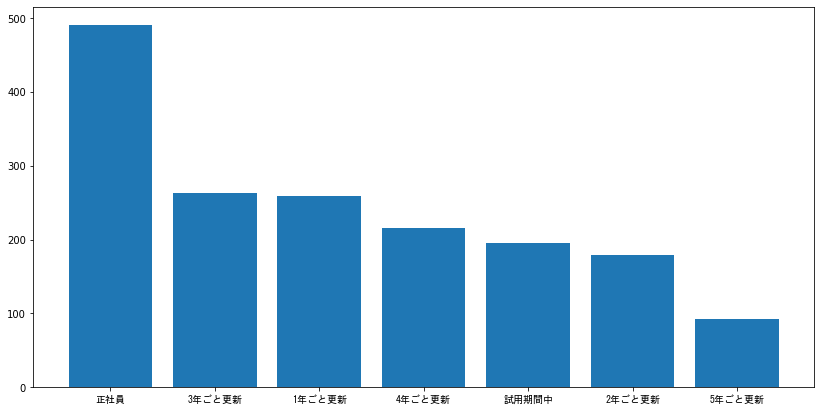

In [38]:
bar_chart('employment_status',2,7)

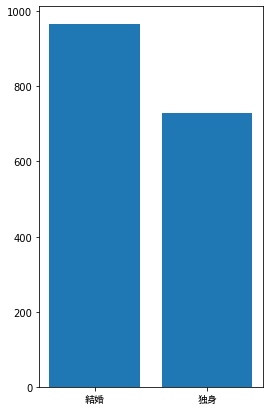

In [42]:
bar_chart('marital_status')

In [59]:
TARGET = 'retirement_flg'
FEATURES = [col for col in df.columns if col != TARGET]

num_cols = [col for col in FEATURES if df[col].dtype != object]
cat_cols = [col for col in FEATURES if col not in num_cols]

cat_cols

['department',
 'job_rank_cd',
 'sex',
 'marital_status',
 'employment_status',
 'allowance',
 'affiliated_subsidiary_name',
 'compensation_system',
 'work_type']

In [68]:
df[df.retirement_flg==0].department.unique()

array(['開発', 'バックオフィス', '営業'], dtype=object)

In [155]:
a = df.employment_status.unique()
print(a)
b = df[df.retirement_flg==1]['employment_status'].value_counts()
print(b)
# print(b['2年ごと更新'])
c = [b[label] for label in a]
print(c)
# print(df[df.retirement_flg==1]['employment_status'].value_counts())
# print(df[df.retirement_flg==0]['employment_status'].value_counts())
# print(df['employment_status'].value_counts())

['3年ごと更新' '正社員' '5年ごと更新' '1年ごと更新' '試用期間中' '4年ごと更新' '2年ごと更新']
2年ごと更新    71
3年ごと更新    61
正社員       53
1年ごと更新    41
4年ごと更新    18
試用期間中      9
5年ごと更新     8
Name: employment_status, dtype: int64
[61, 53, 8, 41, 9, 18, 71]


In [162]:
def multi_bar_chart(col, bar_w=0.35, graph_h=7, type='grouped', val_type='count'):
    labels = df[col].unique()
    retired_temp = df[df.retirement_flg==1][col].value_counts()
    not_retired_temp = df[df.retirement_flg==0][col].value_counts()

    if val_type == 'percent':
        count_all=df[col].value_counts()
        for label in labels:
            retired = [retired_temp[label] / count_all[label] for label in labels]
            not_retired = [not_retired_temp[label] / count_all[label] for label in labels]
    else:
        retired = [retired_temp[label]  for label in labels]
        not_retired = [not_retired_temp[label] for label in labels]


    x = np.arange(len(labels))  # the label locations
    width = bar_w  # the width of the bars

    fig, ax = plt.subplots(figsize=(len(labels)*1.5, graph_h))
    if type=='grouped':
        rects1 = ax.bar(x - width/2, retired, width, label='Retired')
        rects2 = ax.bar(x + width/2, not_retired, width, label='Not Retired')
    if type=='stacked':
        rects1 = ax.bar(x, retired, width, label='Retired')
        rects2 = ax.bar(x, not_retired, width, bottom=retired, label='Not Retired')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Count')
    ax.set_title(f'Count retired and not-retired by {col}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontname='MS Gothic')
    ax.legend()

    fig.tight_layout()

    plt.show()

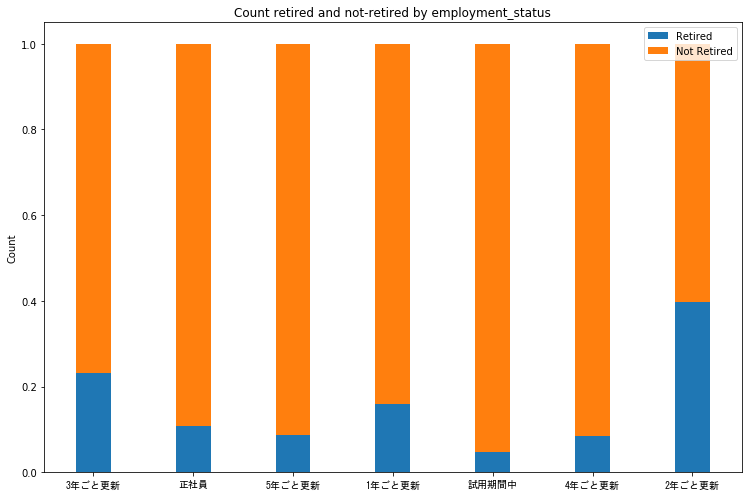

In [163]:
multi_bar_chart('employment_status',0.35, 7, "stacked", "percent")

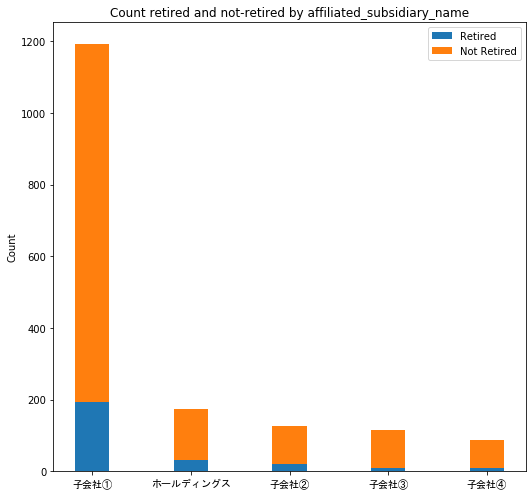

In [118]:
multi_bar_chart('affiliated_subsidiary_name', 0.35, 7, 'stacked')

In [108]:
print('Median')
print(df.groupby('retirement_flg')['number_of_years_in_current_position'].median())
print('Mean')
print(df.groupby('retirement_flg')['number_of_years_in_current_position'].mean())

Median
retirement_flg
0    1.458333
1    1.250000
Name: number_of_years_in_current_position, dtype: float64
Mean
retirement_flg
0    2.591527
1    2.793103
Name: number_of_years_in_current_position, dtype: float64


In [ ]:
#TODO:
# Create new feature: years from contract renewal based on employment status and year in current position
# Create past version of people as new data points